In [1]:
from SimPEG import Mesh, Utils, Maps, Survey
from SimPEG.EM.Static import DC, IP
from SimPEG.EM.Static import Utils as StaticUtils
from pymatsolver import MumpsSolver
import timeit
import itertools
%pylab inline

/Users/sgkang/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Create tensor mesh
# Minimum cell size in each direction
dx = 10.
dy = 10.
dz = 10.

# Number of core cells in each direction
nCoreX = 110.
nCoreY = 110.
nCoreZ = 60.

nPadX = 7
nPadY = 7
nPadZ = 7

# Cell widths
hx = [(dx,nPadX, -1.3),(dx,nCoreX),(dx,nPadX, 1.3)]
hy = [(dy,nPadY, -1.3),(dy,nCoreY),(dy,nPadY, 1.3)]
hz = [(dz,nPadZ, -1.3),(dz,nCoreZ),(dz,nPadZ, 1.3)]

# Calculate X padding distance
hPadX = np.zeros([nPadX+1,1])
hPadX[0] = dx
for i in range (1,nPadX+1):
    hPadX[i] = hPadX[i-1]*1.3

xPadDist = np.max(np.cumsum(hPadX[1:nPadX+1]))

# Calculate Y padding distance
hPadY = np.zeros([nPadY+1,1])
hPadY[0] = dy
for i in range (1,nPadY+1):
    hPadY[i] = hPadY[i-1]*1.3

yPadDist = np.max(np.cumsum(hPadY[1:nPadY+1]))

# Calculate Z padding distance
hPadZ = np.zeros([nPadZ+1,1])
hPadZ[0] = dz
for i in range (1,nPadZ+1):
    hPadZ[i] = hPadZ[i-1]*1.3

zPadDist = np.max(np.cumsum(hPadZ[1:nPadZ+1]))

# Desired Core mesh origin (Bottom SW corner)
topoShift = 200.

x0_core = -(nCoreX/2)*dx - dx/2.
y0_core = -(nCoreY/2)*dy - dy/2.
z0_core = -nCoreZ*dz + topoShift - dz/2.

# Mesh origin (Bottom SW corner)
x0 = x0_core - xPadDist
y0 = y0_core - yPadDist
z0 = z0_core - zPadDist

mesh = Mesh.TensorMesh([hx, hy, hz],[x0,y0,z0])
# x0 = mesh.x0
# xc = 300+5.57e5
# yc = 600+7.133e6
# zc = 425.
# mesh._x0 = np.r_[x0[0]+xc, x0[1]+yc, x0[1]+zc]
# mesh.writeUBC("./Geological_model/TKC_Synth_DC_10mCells.msh")

In [3]:
# mesh = Mesh.TensorMesh.readUBC("./Geological_model/TKC_Synth_DC_10mCells.msh")

In [4]:
print mesh
print mesh.nC

  ---- 3-D TensorMesh ----  
   x0: -783.58
   y0: -783.58
   z0: -633.58
  nCx: 124
  nCy: 124
  nCz: 74
   hx: 62.75, 48.27, 37.13, 28.56, 21.97, 16.90, 13.00, 110*10.00, 13.00, 16.90, 21.97, 28.56, 37.13, 48.27, 62.75
   hy: 62.75, 48.27, 37.13, 28.56, 21.97, 16.90, 13.00, 110*10.00, 13.00, 16.90, 21.97, 28.56, 37.13, 48.27, 62.75
   hz: 62.75, 48.27, 37.13, 28.56, 21.97, 16.90, 13.00, 60*10.00, 13.00, 16.90, 21.97, 28.56, 37.13, 48.27, 62.75
1137824


(<matplotlib.collections.QuadMesh at 0x114e5f210>,
 <matplotlib.lines.Line2D at 0x114e5f750>)

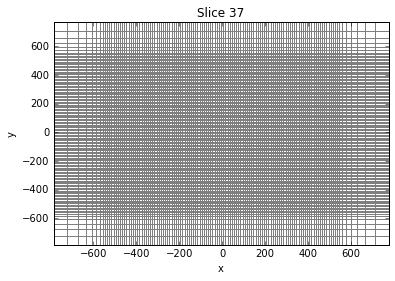

In [5]:
mesh.plotSlice(np.ones(mesh.nC)*np.nan, grid=True)

In [6]:
# Load TKC synthetic model
sigma = mesh.readModelUBC("./Geological_model/VTKout_DC_10mCells.dat")

In [7]:
def gettopoCC(mesh, airind):
# def gettopoCC(mesh, airind):
    """
        Get topography from active indices of mesh.
    """
    mesh2D = Mesh.TensorMesh([mesh.hx, mesh.hy], mesh.x0[:2])
    zc = mesh.gridCC[:,2]
    AIRIND = airind.reshape((mesh.vnC[0]*mesh.vnC[1],mesh.vnC[2]), order='F')
    ZC = zc.reshape((mesh.vnC[0]*mesh.vnC[1], mesh.vnC[2]), order='F')
    topo = np.zeros(ZC.shape[0])
    topoCC = np.zeros(ZC.shape[0])
    for i in range(ZC.shape[0]):
        ind  = np.argmax(ZC[i,:][~AIRIND[i,:]])        
        topo[i] = ZC[i,:][~AIRIND[i,:]].max() + mesh.hz[~AIRIND[i,:]][ind]*0.5        
        topoCC[i] = ZC[i,:][~AIRIND[i,:]].max()
    XY = Utils.ndgrid(mesh.vectorCCx, mesh.vectorCCy)
    return mesh2D, topoCC

-150.0


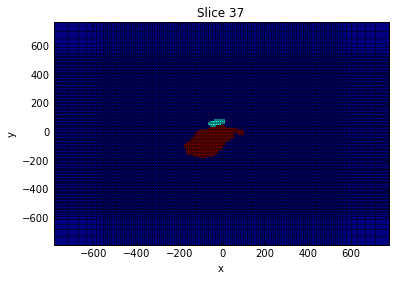

In [8]:
mesh.plotSlice(np.log10(sigma), grid=True)
print mesh.vectorCCz[32]

(<matplotlib.collections.QuadMesh at 0x1154eadd0>,
 <matplotlib.lines.Line2D at 0x115540350>)

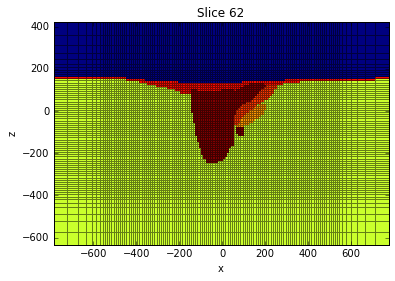

In [9]:
mesh.plotSlice(np.log10(sigma), grid=True, normal="Y")

In [10]:
# Identify air cells
airind = sigma==1e-8
mesh2D, topoCC = gettopoCC(mesh, airind)


In [11]:
# Define electrode locations

elecSpace = 50.
coreOffset = 100 + dx/2.

# x locations
elecX = np.linspace(x0_core + coreOffset , np.abs(x0_core) - coreOffset, num=((2*(np.abs(x0_core)-coreOffset))/elecSpace) + 1)
nElecX = elecX.size
# y locations
elecY = np.linspace(y0_core + coreOffset , np.abs(y0_core) - coreOffset, num=((2*(np.abs(y0_core)-coreOffset))/elecSpace) + 1)
nElecY = elecY.size

# Insure that electrode x and y locations fall at cell centres
xCC = mesh.vectorCCx[np.logical_and(mesh.vectorCCx > x0_core, mesh.vectorCCx < np.abs(x0_core))]
yCC = mesh.vectorCCy[np.logical_and(mesh.vectorCCy > y0_core, mesh.vectorCCy < np.abs(y0_core))]

elecX_unique_sorted, elecX_ind = np.unique(elecX, return_index=True)
elecX_in_xCC_bool = np.in1d(elecX_unique_sorted, xCC, assume_unique=True)
print elecX_in_xCC_bool

print xCC

print elecX

elecY_unique_sorted, elecY_ind = np.unique(elecY, return_index=True)
elecY_in_yCC_bool = np.in1d(elecY_unique_sorted, xCC, assume_unique=True)
print elecY_in_yCC_bool

                                    
elecX_grid,elecY_grid = np.meshgrid(elecX,elecY)

EW_Lines_Locs = []
EW_Lines_Id =[]
for ii in range(0, nElecY): 
    EW_Lines_Locs.append(np.vstack([elecX_grid[ii,:], elecY_grid[ii,:]]).T)
    EW_Lines_Id.append(np.arange(nElecX*ii,nElecX*ii + nElecX,1))
    
# Create full electrode key which maps electrode Ids and locations
elecLoc = np.vstack(EW_Lines_Locs)

# Drape to topography to get z-value
elecCC_Inds = Utils.closestPoints(mesh2D, elecLoc)
elecLoc_topo = np.c_[elecLoc[:,0], elecLoc[:,1], topoCC[elecCC_Inds]]

nElec = elecLoc_topo.shape[0]
elecId = np.arange(0,nElec,1)

elecLocKey = np.hstack([Utils.mkvc(elecId,2),elecLoc_topo])    

# print EW_Lines_Id[18]    
    
NS_Lines_Locs = []
NS_Lines_Id = []
for ii in range(0, nElecX): 
    NS_Lines_Locs.append(np.vstack([elecX_grid[:,ii], elecY_grid[:,ii]]).T)
    NS_Lines_Id.append(np.arange(ii,nElec,nElecX))
    
# print NS_Lines_Id[18] 


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True False False False False False]
[-550.  -540.  -530.  -520.  -510.  -500.  -490.  -480.  -470.  -460.  -450.
 -440.  -430.  -420.  -410.  -400.  -390.  -380.  -370.  -360.  -350.  -340.
 -330.  -320.  -310.  -300.  -290.  -280.  -270.  -260.  -250.  -240.  -230.
 -220.  -210.  -200.  -190.  -180.  -170.  -160.  -150.  -140.  -130.  -120.
 -110.  -100.   -90.   -80.   -70.   -60.   -50.   -40.   -30.   -20.   -10.
    0.    10.    20.    30.    40.    50.    60.    70.    80.    90.   100.
  110.   120.   130.   140.   150.   160.   170.   180.   190.   200.   210.
  220.   230.   240.   250.   260.   270.   280.   290.   300.   310.   320.
  330.   340.   350.   360.   370.   380.   390.   400.   410.   420.   430.
  440.   450.   460.   470.   480.   490.   500.   510.   520.   530.   540.
  551.5]
[-450. -400. -350. -300. -250. -200. -150. -100.  -50.    0.   50.  100.
  150.  200.  250.  300.  350. 

In [12]:
print EW_Lines_Locs[0]
print EW_Lines_Locs[0].shape
# print elecY

[[-450. -450.]
 [-400. -450.]
 [-350. -450.]
 [-300. -450.]
 [-250. -450.]
 [-200. -450.]
 [-150. -450.]
 [-100. -450.]
 [ -50. -450.]
 [   0. -450.]
 [  50. -450.]
 [ 100. -450.]
 [ 150. -450.]
 [ 200. -450.]
 [ 250. -450.]
 [ 300. -450.]
 [ 350. -450.]
 [ 400. -450.]
 [ 450. -450.]]
(19, 2)


In [13]:
print NS_Lines_Locs[0]
print NS_Lines_Locs[0].shape[0]

[[-450. -450.]
 [-450. -400.]
 [-450. -350.]
 [-450. -300.]
 [-450. -250.]
 [-450. -200.]
 [-450. -150.]
 [-450. -100.]
 [-450.  -50.]
 [-450.    0.]
 [-450.   50.]
 [-450.  100.]
 [-450.  150.]
 [-450.  200.]
 [-450.  250.]
 [-450.  300.]
 [-450.  350.]
 [-450.  400.]
 [-450.  450.]]
19


In [14]:
EW_Lines_Id[1]

array([19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37])

In [15]:
# Create dipole-dipole sequence for each EW line

# Identify Tx dipoles on each line
EW_Line_TxElecInd = []
EW_LineId = []
EW_nLines = nElecY
for nr, Line_ElecIds in enumerate(EW_Lines_Id):
    Line_nElec = Line_ElecIds.shape[0]
    for ii in Line_ElecIds[0:-1]:
        for jj in np.arange(ii+1,np.max(Line_ElecIds)+1,1):
            EW_Line_TxElecInd.append([ii , jj])
            EW_LineId.append([nr])

EW_Line_TxElecInd = np.array(EW_Line_TxElecInd)
EW_LineId = np.array(EW_LineId)
nTx = np.array(EW_Line_TxElecInd).shape[0]  
nTx_Line = nTx/EW_nLines

# print nTx
# print nTx_Line
# print EW_Line_TxElecInd[0:nTx_Line,:]
    

In [16]:
print EW_Line_TxElecInd.shape

(3249, 2)


In [17]:
dataDict = {}
# nRxList = []
# Iterate over Tx and select possible Rx for each
nTx = 1 # just for testing
for nr, Tx in enumerate(EW_Line_TxElecInd[0:1,:]):
#     print nr, Tx
    LineId = EW_LineId[nr]
    useableRxElecs = np.setdiff1d(EW_Lines_Id[LineId[0]],Tx)
    RxPairs = itertools.combinations(useableRxElecs,2) # n choose k combinations
    
    # Extract data from combinations object
    RxPairList = []
    for ii in RxPairs:
        RxPairList.append(tuple(ii))

    RxPairArray = np.array(RxPairList)
    nRx = RxPairArray.shape[0]
#     nRxList.append([nRx])
    
    A = Tx[0]*np.ones((nRx,1))
    B = Tx[1]*np.ones((nRx,1))
    LineIdVec = LineId*np.ones((nRx,1))
    dataArray = np.hstack([LineIdVec,A,B,RxPairArray])
    dataDict[nr] = dataArray

In [18]:
# Create Tx and Rx data objects for the survey object

FullElecSeqList = []
for Tx in dataDict.keys(): 
    FullElecSeqList.append(dataDict[Tx][:,1:5])

# print "nTx = %i" % (nTx)

FullElecSeqArray = np.array(FullElecSeqList)
print FullElecSeqArray.shape
print nTx
FullElecSeq = FullElecSeqArray.reshape(nTx*nRx,4)
FullElecSeq.shape

nData = FullElecSeq.shape[0]
# print nData

AIds = FullElecSeq[:,0]
BIds = FullElecSeq[:,1]
MIds = FullElecSeq[:,2]
NIds = FullElecSeq[:,3]

ALoc = np.zeros([nData,3])
BLoc = np.zeros([nData,3])
MLoc = np.zeros([nData,3])
NLoc = np.zeros([nData,3])


print elecLoc_topo.shape

for ii in range(0, nElec-1):
    AInd = np.where(AIds == ii)
    ALoc[AInd,:] = elecLoc_topo[ii,:]
    
    BInd = np.where(BIds == ii)
    BLoc[BInd,:] = elecLoc_topo[i,:]
    
    MInd = np.where(MIds == ii)
    MLoc[MInd,:] = elecLoc_topo[i,:]
    
    NInd = np.where(NIds == ii)
    NLoc[NInd,:] = elecLoc_topo[ii,:]

RxData = DC.Rx.Dipole(MLoc, NLoc)
TxData = DC.Src.Dipole([RxData], np.array(ALoc),np.array(BLoc))

(1, 136, 4)
1
(361, 3)


In [19]:
# Model mappings 
expmap = Maps.ExpMap(mesh)
actmap = Maps.InjectActiveCells(mesh, ~airind, np.log(1e-8))
mapping = expmap*actmap

In [20]:
# reference model
m0 = np.ones_like(sigma)[~airind]*np.log(1e-4)

In [21]:
# Setup forward modelling
survey = DC.Survey([TxData])
problem = DC.Problem3D_CC(mesh, mapping=mapping)
problem.Solver = MumpsSolver
problem.pair(survey)
mtrue = np.log(sigma)[~airind]
startTime = timeit.timeit()
f = problem.fields(mtrue)
endTime = timeit.timeit()
print endTime - startTime
dobs = survey.dpred(mtrue, f=f)
survey.dobs = dobs

TypeError: not all arguments converted during string formatting

In [ ]:
dcdata = Survey.Data(survey, v=dobs)
Xx = 0.5*(Mx[:,0]+Nx[:,0]).reshape((23, 24), order="F")
Yx = Mx[:,1].reshape((23, 24), order="F")
Xy = My[:,0].reshape((24, 23), order="F")
Yy = 0.5*(My[:,1]+Ny[:,1]).reshape((24, 23), order="F")

In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(5,5))
# ax.plot(Aloc1_x[0], Aloc1_x[1], 'ro', ms=5)
# ax.plot(Bloc1_x[0], Bloc1_x[1], 'bo', ms=5)
# ax.plot(Aloc2_x[0], Aloc2_x[1], 'ro', ms=5)
# ax.plot(Bloc2_x[0], Bloc2_x[1], 'bo', ms=5)
# ax.plot(Aloc1_y[0], Aloc1_y[1], 'ro', ms=5)
# ax.plot(Bloc1_y[0], Bloc1_y[1], 'bo', ms=5)
# ax.plot(Aloc2_y[0], Aloc2_y[1], 'ro', ms=5)
# ax.plot(Bloc2_y[0], Bloc2_y[1], 'bo', ms=5)

# ax.plot(Mx[:,0], Mx[:,1], 'k.', ms=2)
# ax.plot(Nx[:,0], Nx[:,1], 'g.', ms=2)

# # ax.plot(My[:,0], My[:,1], 'k.', ms=2)
# # ax.plot(Ny[:,0], Ny[:,1], 'g.', ms=2)
# # dat = mesh2D.plotImage(topoCC, ax=ax, pcolorOpts={'alpha':0.2})
# # plt.colorbar(dat[0])
# ax.set_xlim(-800, 800)
# ax.set_ylim(-800, 800)
# ax.set_xlabel("Easting (m)")
# ax.set_ylabel("Northing (m)") 

In [ ]:
from ipywidgets import interact, IntSlider
def viz(sigma, ind, normal="Z"):
    # sigma = np.ones(mesh.nC)*np.nan
    
    if normal == "Z":
        figsize(5*1.2, 5)
    else:
        figsize(5*1.2, 2.5)

#     print mesh.vectorCCz[ind]
    temp = sigma.copy()
    temp[airind] = np.nan
    dat = mesh.plotSlice(np.log10(sigma), ind=ind, clim=(-4, -1), normal=normal, grid=True)
    plt.xlabel("Easting (m)")
    plt.ylabel("Northing (m)")    
    # plt.axis("equal")
    if normal == "Z":
        xlim(-600, 600)
        ylim(-600, 600.)    
    else:
        xlim(-600, 600)
        ylim(-600, 0.)     
    cb = plt.colorbar(dat[0], format="$10^{%1.1f}$")        
    cb.set_label("Conductivity (S/m)")
    plt.title(" ")

In [ ]:
from ipywidgets import interact, IntSlider
def vizEJ(sigma, ind, normal="Z", ftype="E"):
    # sigma = np.ones(mesh.nC)*np.nan
    
    if normal == "Z":
        figsize(5*1.2, 5)
    else:
        figsize(5*1.2, 2.5)

#     print mesh.vectorCCz[ind]
    temp = sigma.copy()
    temp[airind] = np.nan

    if ftype == "E":
#         vmin, vmax = abs(f[src1,'e']).min(), abs(f[src1,'e']).max()*0.5   
        dat=mesh.plotSlice(f[src1,'e'], vType="F", view="vec", ind=ind, normal=normal, grid=False, streamOpts={'color':'w'})
        plt.title("Electric fields (V/m)")
    elif ftype == "charg":
        dat=mesh.plotSlice(f[src1,'charge'], ind=ind, normal=normal)
        plt.title("Electric charges (C)")        
    elif ftype == "J":
        dat=mesh.plotSlice(f[src1,'j'], vType="F", view="vec", ind=ind, normal=normal, grid=False, streamOpts={'color':'w'})
        plt.title("Electric currents (V/m)")
    plt.xlabel("Easting (m)")
    
    # plt.axis("equal")
    if normal == "Z":
        xlim(-600, 600)
        ylim(-600, 600.)    
        plt.ylabel("Northing (m)")        
    else:
        xlim(-600, 600)
        ylim(-600, 0.)  
        plt.ylabel("Depth (m)")
    plt.colorbar(dat[0], format="%1.1e")

In [ ]:
def vizdata(data, src, rx, rxcomponent="X", clim=None):
    figsize(5,5)
    temp = data[src, rx]
    if rxcomponent=="X":
        X = Xx.copy()
        Y = Yx.copy()        
    else:
        X = Xy.copy()
        Y = Yy.copy()      
    temp = temp.reshape(X.shape, order="F")
    if clim is not None:
        vmin, vmax = clim[0], clim[1]
        dat = plt.contourf(X, Y, temp, 20, clim=clim, vmin=vmin, vmax=vmax)
    else:
        dat = plt.contourf(X, Y, temp, 20)
    plt.xlabel("Easting (m)")
    plt.ylabel("Northing (m)")            
    plt.colorbar(dat)

<function __main__.<lambda>>

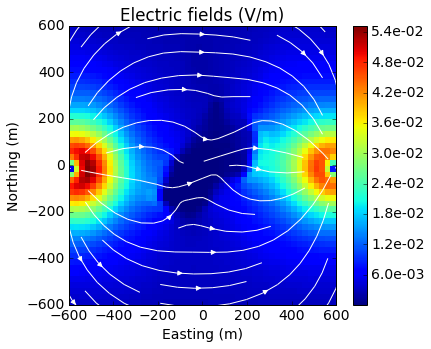

In [19]:
interact(lambda ind: vizEJ(sigma, ind, normal="Z", ftype="E"), ind=IntSlider(min=0, max=32,step=1, value=25))

<function __main__.<lambda>>

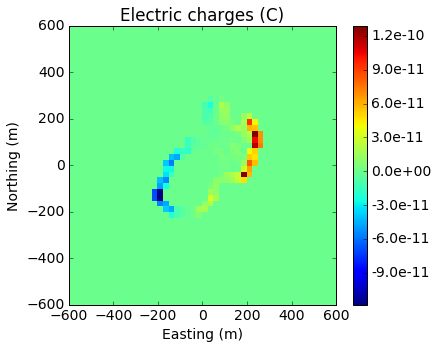

In [20]:
interact(lambda ind: vizEJ(sigma, ind, normal="Z", ftype="charg"), ind=IntSlider(min=0, max=32,step=1, value=25))

<function __main__.<lambda>>

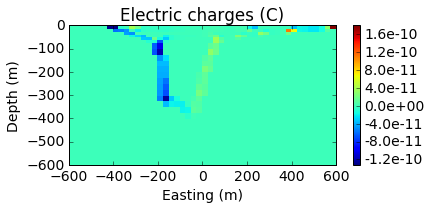

In [21]:
interact(lambda ind: vizEJ(sigma, ind, normal="Y", ftype="charg"), ind=IntSlider(min=0, max=32,step=1, value=25))

<function __main__.<lambda>>

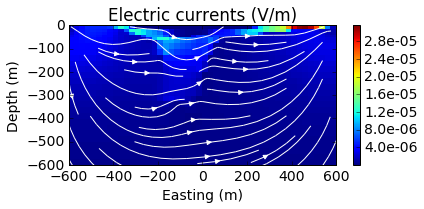

In [22]:
interact(lambda ind: vizEJ(sigma, ind, normal="Y", ftype="J"), ind=IntSlider(min=0, max=32,step=1, value=25))

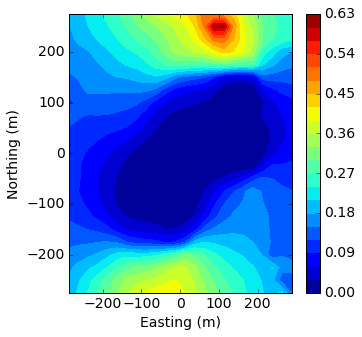

In [23]:
vizdata(dcdata, src3, rx_y, rxcomponent="Y")

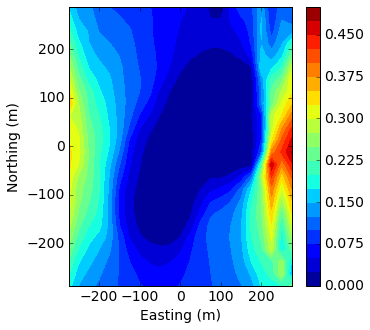

In [24]:
vizdata(dcdata, src1, rx_x, rxcomponent="X")

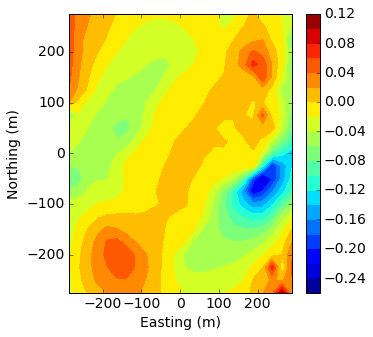

In [25]:
vizdata(dcdata, src1, rx_y, rxcomponent="Y")

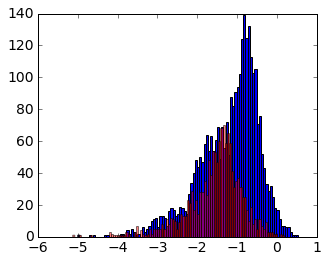

In [26]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
a = ax.hist(np.log10(dobs[dobs>0.]), bins=100)
b = ax.hist(np.log10(-dobs[dobs<0.]), bins=100, color='r', alpha=0.5)

In [27]:
depth = 1./(abs(mesh.gridCC[:,2]))**1.5
depth = depth/depth.max()

(-600, 0.0)

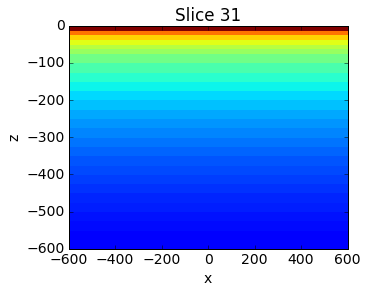

In [28]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
mesh.plotSlice(np.log10(depth), normal="Y", streamOpts={'color':'w'}, ax=ax)
ax.set_xlim(-600, 600)
ax.set_ylim(-600, 0.)    

In [29]:
# from SimPEG import DataMisfit, Regularization, Optimization, Directives, InvProblem, Inversion
# regmap = Maps.IdentityMap(nP=m0.size)
# std = 0.05
# eps = 1e-3
# survey.std = std
# survey.eps = eps
# #TODO put warning when dobs is not set!
# survey.dobs = dobs
# dmisfit = DataMisfit.l2_DataMisfit(survey)
# reg = Regularization.Simple(mesh, mapping=regmap, indActive=~airind)
# reg.wght = depth[~airind]
# opt = Optimization.InexactGaussNewton(maxIter = 20)
# invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
# # Create an inversion object
# beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=2)
# betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
# save = Directives.SaveOutputEveryIteration()
# target = Directives.TargetMisfit()
# inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest, save, target])
# reg.alpha_s = 1e-4
# reg.alpha_x = 1.
# reg.alpha_y = 1.
# reg.alpha_z = 1.
# problem.counter = opt.counter = Utils.Counter()
# opt.LSshorten = 0.5
# opt.remember('xc')
# mopt = inv.run(m0)
# sigopt = mapping*mopt
# np.save("sigest", sigopt)

In [30]:
sigopt = np.load("sigest.npy")
# sigopt = mapping*mopt

In [31]:
from SimPEG import Survey
# datapred = invProb.dpred
# obsdata = Survey.Data(survey, v=dobs)
# preddata = Survey.Data(survey, v=datapred)

In [32]:
# figsize(8,3)
# plt.plot(obsdata[src1, rx_y])
# plt.plot(preddata[src1, rx_y], '.')

<function __main__.<lambda>>

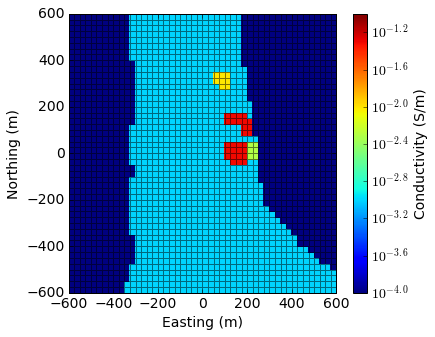

In [33]:
interact(lambda ind: viz(sigma, ind, normal="Z"), ind=IntSlider(min=0, max=32,step=1, value=30))

<function __main__.<lambda>>

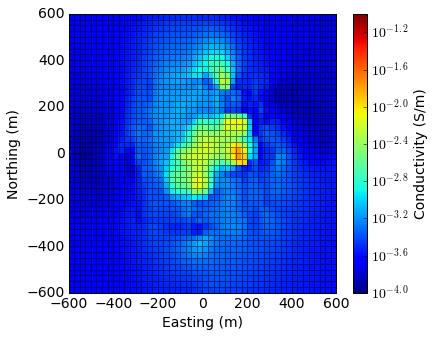

In [34]:
interact(lambda ind: viz(sigopt, ind, normal="Z"), ind=IntSlider(min=0, max=32,step=1, value=30))

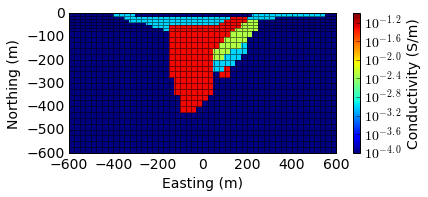

In [35]:
interact(lambda ind: viz(sigma, ind, normal="Y"), ind=IntSlider(min=0, max=32,step=1, value=30))

<function __main__.<lambda>>

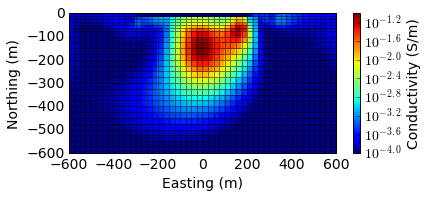

In [36]:
interact(lambda ind: viz(sigopt, ind, normal="Y"), ind=IntSlider(min=0, max=32,step=1, value=30))

In [37]:
import pickle
Results = {"mesh":mesh, "model_true":sigma, "model_pred":sigopt, "Obs":dobs}
outputs = open("DCresults", 'wb')
pickle.dump(Results, outputs)
outputs.close()